# *Explainable Artificial Intelligence:*
comparing two different explainability approaches for a CNN classifier trained on the CUB-200 dataset.

Final Project - ML course 2023 - María Paz Oliva.

The goal of this notebook is to assess the performance of two different explainability approaches, perturbation-based versus gradient-based, on a CNN classifier trained on the CUB-200 dataset.

The code will be structured as follows:
1. Loading data (CUB-200 Dataset)
2. Training CNN Classifier
3. Implementing LIME
4. Implementing Integrated Gradients
5. Evaluating and comparing the explanations

# 1. Loading data (CUB-200 Dataset)



On this section I parse the metadata files from CUB-200-2011 and create a dataset and data loader for PyTorch.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

Class CUB200Dataset: custom PyTorch dataset implementation for loading and preprocessing images and their corresponding labels from the CUB-200 dataset.

In [ ]:
class CUB200Dataset(Dataset):
    """ Custom implementation of a PyTorch Dataset for loading the CUB-200 dataset."""
    def __init__(self, img_dir, img_list, class_labels, transform=None, part_locs=None, bounding_boxes=None):
        self.img_dir = img_dir
        self.img_list = img_list
        self.class_labels = class_labels
        self.transform = transform
        self.part_locs = part_locs
        self.bounding_boxes = bounding_boxes

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx][1])
        image = Image.open(img_path).convert('RGB')
        original_size = image.size  # Original size of the image
        label = self.class_labels[idx][1] - 1

        if self.transform:
            image = self.transform(image)

        if self.part_locs is not None:
            parts = self.part_locs[self.part_locs['img_id'] == idx + 1].copy()
            parts['x'] *= (224 / original_size[0])
            parts['y'] *= (224 / original_size[1])
            parts = parts[['x', 'y']].values
        else:
            parts = None

        if self.bounding_boxes is not None:
            bbox = self.bounding_boxes[self.bounding_boxes['img_id'] == idx + 1].copy()
            bbox['x'] *= (224 / original_size[0])
            bbox['y'] *= (224 / original_size[1])
            bbox['width'] *= (224 / original_size[0])
            bbox['height'] *= (224 / original_size[1])
            bbox = bbox[['x', 'y', 'width', 'height']].values[0]
        else:
            bbox = None

        return image, label, parts, bbox

Loader function: reads and processes metadata files from the CUB-200 dataset to split image file paths and labels into training and testing sets.


In [ ]:
def load_metadata(data_dir):
    """Read and process the metadata files associated with the CUB-200 dataset."""
    images = pd.read_csv(os.path.join(data_dir, 'images.txt'), sep=' ', header=None, names=['img_id', 'filepath'])
    labels = pd.read_csv(os.path.join(data_dir, 'image_class_labels.txt'), sep=' ', header=None, names=['img_id', 'class_id'])
    train_test_split = pd.read_csv(os.path.join(data_dir, 'train_test_split.txt'), sep=' ', header=None, names=['img_id', 'is_training'])
    part_locs = pd.read_csv(os.path.join(data_dir, 'parts/part_locs.txt'), sep=' ', header=None, names=['img_id', 'part_id', 'x', 'y', 'visible'])
    bounding_boxes = pd.read_csv(os.path.join(data_dir, 'bounding_boxes.txt'), sep=' ', header=None, names=['img_id', 'x', 'y', 'width', 'height'])

    train_images = images[train_test_split['is_training'] == 1].values
    test_images = images[train_test_split['is_training'] == 0].values
    train_labels = labels[train_test_split['is_training'] == 1].values
    test_labels = labels[train_test_split['is_training'] == 0].values

    return train_images, test_images, train_labels, test_labels, part_locs, bounding_boxes

In [ ]:
data_dir = '/content/drive/My Drive/LCT TRENTO/ML FINAL PROJECT/CUB_200_2011/CUB_200_2011'
train_images, test_images, train_labels, test_labels, part_locs, bounding_boxes = load_metadata(data_dir)

Transformations:
*   Resize: ensure all images are the same size.
*   ToTensor: convert images to a format usable by PyTorch and scales pixel values.
*   Normalize: standardize the input data to match the distribution






In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize all images to a uniform size of 224x224 pixels
    transforms.ToTensor(), #  convert a PIL image or numpy array to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #  normalize the image tensor using the specified mean and standard deviation for each channel (RGB)
])

In [ ]:
train_dataset = CUB200Dataset(img_dir=os.path.join(data_dir, 'images'), img_list=train_images, class_labels=train_labels, transform=transform)
test_dataset = CUB200Dataset(img_dir=os.path.join(data_dir, 'images'), img_list=test_images, class_labels=test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Small visualization of sample data.

In [ ]:
def get_dataset_info(dataset):
    labels = [label for _, label in dataset]
    unique_labels = set(labels)
    label_counts = {label: labels.count(label) for label in unique_labels}
    return len(labels), len(unique_labels), label_counts

In [ ]:
train_size, num_train_labels, train_label_counts = get_dataset_info(train_dataset)
test_size, num_test_labels, test_label_counts = get_dataset_info(test_dataset)

In [ ]:
print(f'Train set size: {train_size}')
print(f'Test set size: {test_size}')
print(f'Number of labels in train set: {num_train_labels}')
print(f'Number of labels in test set: {num_test_labels}')
print(f'Examples per label in train set: {train_label_counts}')
print(f'Examples per label in test set: {test_label_counts}')

Train set size: 5994
Test set size: 5794
Number of labels in train set: 200
Number of labels in test set: 200
Examples per label in train set: {0: 30, 1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30, 8: 30, 9: 30, 10: 30, 11: 30, 12: 30, 13: 30, 14: 30, 15: 30, 16: 30, 17: 30, 18: 30, 19: 30, 20: 30, 21: 30, 22: 30, 23: 30, 24: 30, 25: 30, 26: 30, 27: 30, 28: 30, 29: 30, 30: 30, 31: 30, 32: 30, 33: 30, 34: 30, 35: 30, 36: 30, 37: 30, 38: 30, 39: 30, 40: 30, 41: 30, 42: 30, 43: 30, 44: 30, 45: 30, 46: 30, 47: 30, 48: 30, 49: 30, 50: 30, 51: 30, 52: 30, 53: 30, 54: 30, 55: 30, 56: 30, 57: 30, 58: 30, 59: 30, 60: 30, 61: 30, 62: 30, 63: 30, 64: 30, 65: 30, 66: 30, 67: 30, 68: 30, 69: 30, 70: 30, 71: 30, 72: 30, 73: 30, 74: 30, 75: 30, 76: 30, 77: 30, 78: 30, 79: 30, 80: 30, 81: 30, 82: 30, 83: 30, 84: 30, 85: 30, 86: 30, 87: 30, 88: 30, 89: 30, 90: 30, 91: 30, 92: 30, 93: 30, 94: 30, 95: 30, 96: 30, 97: 30, 98: 30, 99: 30, 100: 30, 101: 30, 102: 30, 103: 30, 104: 30, 105: 30, 106: 29, 107

Display 3 example images from different labels

In [ ]:
def load_bird_names(data_dir):
    classes = pd.read_csv(os.path.join(data_dir, 'classes.txt'), sep=' ', header=None, names=['class_id', 'class_name'])
    class_dict = classes.set_index('class_id')['class_name'].to_dict()
    return class_dict

bird_names = load_bird_names(data_dir)

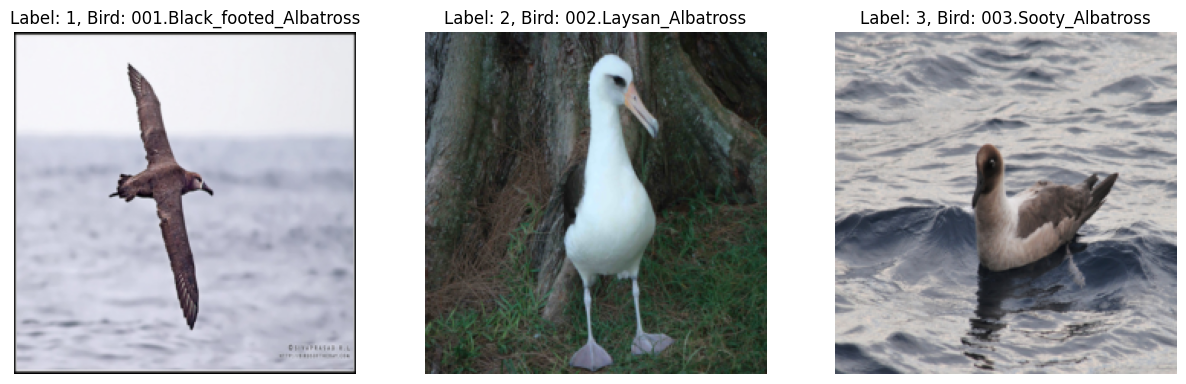

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_example_images(dataset, bird_names, num_examples=3):
    labels = [label for _, label in dataset]
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

    for i, ax in enumerate(axes):
        label = unique_labels[i]
        idx = labels.index(label)
        image, _ = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        bird_name = bird_names[label + 1]
        ax.imshow(image)
        ax.set_title(f'Label: {label + 1}, Bird: {bird_name}')
        ax.axis('off')

    plt.show()

display_example_images(train_dataset, bird_names)

# 2. Training CNN Classifier

In [ ]:
import torch.nn as nn # neural network module from PyTorch
import torch.optim as optim # optimization module from PyTorch
from torchvision import models  # pre-trained models from torchvision

Define the CNN model using a pre-trained ResNet18:
*   Define a custom class for the CNN model, inheriting from nn.Module.
*   Initialize the model with the number of classes in the dataset.
*   Load a pre-trained ResNet18 model.
*   Get the number of input features to the final fully connected layer.
*   Replace the final fully connected layer with a new one that has the correct number of output classes.
*   Define the forward pass of the model.
*   Return the output of the ResNet18 model.

In [ ]:
class CUBResNet(nn.Module):
    def __init__(self, num_classes):
        super(CUBResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

Training function:

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

    return model

Evaluation function:

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct.double() / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Set up the device, model, loss function, and optimize.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CUBResNet(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 32.5MB/s]


Train the model

In [ ]:
model = train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

Epoch 0/9, Loss: 4.3069
Epoch 1/9, Loss: 2.7503
Epoch 2/9, Loss: 1.9187
Epoch 3/9, Loss: 1.3320
Epoch 4/9, Loss: 0.8754
Epoch 5/9, Loss: 0.5297
Epoch 6/9, Loss: 0.2790
Epoch 7/9, Loss: 0.1543
Epoch 8/9, Loss: 0.0977
Epoch 9/9, Loss: 0.1096



Evaluate the model

In [ ]:
evaluate_model(model, test_loader, criterion, device)

Test Loss: 2.6222, Accuracy: 0.4424


Save the model:

In [ ]:
save_path = '/content/drive/My Drive/LCT TRENTO/ML FINAL PROJECT/CUB_200_2011/CUB_200_2011/cub200_resnet18.pth'
torch.save(model.state_dict(), save_path)

Reload the model:

In [ ]:
save_path = '/content/drive/My Drive/LCT TRENTO/ML FINAL PROJECT/CUB_200_2011/CUB_200_2011/cub200_resnet18.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CUBResNet(num_classes=200).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


CUBResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

# 3. Implementing LIME

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=f5ee27e5dcdb80c71f8da393ab466a7b0610d2ff7ef9184aa447551909a0b820
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import torch

LIME explainer function

In [ ]:
def explain_with_lime(model, image, device): # provide model and specific image
    explainer = lime_image.LimeImageExplainer() # uses LimeImageExplainer object from lime
    explanation = explainer.explain_instance(
        image,
        classifier_fn=lambda x: model(torch.tensor(x).permute(0, 3, 1, 2).to(device)).detach().cpu().numpy(),
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )
    return explanation

Visualize LIME explanation

In [ ]:
def visualize_lime_explanation(explanation, image, label):
    temp, mask = explanation.get_image_and_mask(
        label, positive_only=True, num_features=10, hide_rest=False
    )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for Label: {label}')
    plt.show()

Example usage with a sample image

  0%|          | 0/1000 [00:00<?, ?it/s]

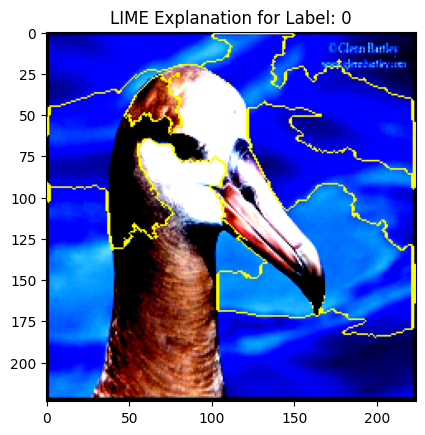

In [ ]:
image, label = test_dataset[0]  # Get the first test image and label
image_np = image.permute(1, 2, 0).numpy()
explanation = explain_with_lime(model, image_np, device)
visualize_lime_explanation(explanation, image_np, label)

# 4. Implementing Integrated Gradients



In [ ]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
import numpy as np
from captum.attr import IntegratedGradients, visualization as viz

Integrated Gradients explainer function

In [ ]:
def explain_with_integrated_gradients(model, image, label, device):
    ig = IntegratedGradients(model) # uses IntegratedGradients object from Captum
    image_tensor = image.unsqueeze(0).to(device)
    attributions_ig = ig.attribute(image_tensor, target=label.item(), n_steps=200)
    return attributions_ig

Visualize Integrated Gradients explanation

In [ ]:
def visualize_ig_explanation(attributions_ig, image):
    _ = viz.visualize_image_attr(
        np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0)),
        np.transpose(image.numpy(), (1, 2, 0)),
        method="heat_map",
        cmap="inferno",
        show_colorbar=True,
        sign="positive",
        outlier_perc=1,
    )

Example usage with a sample image

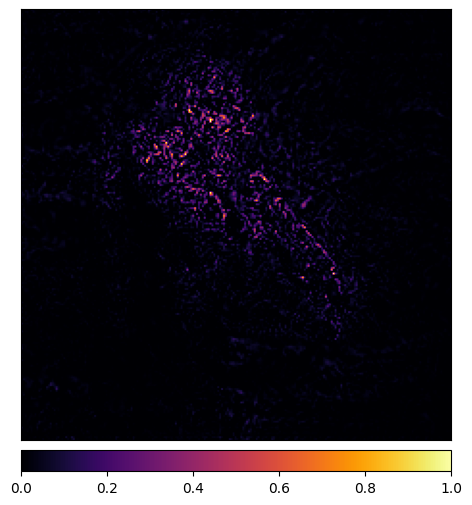

In [ ]:
image, label = test_dataset[0]  # Get the first test image and label
attributions_ig = explain_with_integrated_gradients(model, image, label, device)
visualize_ig_explanation(attributions_ig, image)

# 5. Applying explanations

The purpose of this section is to utilize the two methodologies, LIME and IG, to actually analyze if the model is paying attention to the right features.


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from captum.attr import IntegratedGradients, visualization as viz

This function identifies the smallest rectangle that encloses all the important features in a given mask.

It looks for the rows and columns in the mask that contain important features and returns the coordinates of the bounding box around these features.

In [ ]:
def extract_bounding_box_from_mask(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if np.any(rows) and np.any(cols):
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        return [cmin, rmin, cmax, rmax]
    else:
        return [0, 0, 0, 0]

This function calculates the Intersection over Union (IoU) between two bounding boxes: one from the ground truth annotations and one from the explanation mask. The IoU is a measure of how much the two bounding boxes overlap, which helps determine if the model's important features align with the actual important areas defined by the annotations.



In [ ]:
def calculate_iou(annotation, explanation_mask):
    x_min, y_min, width, height = annotation['x'], annotation['y'], annotation['width'], annotation['height']
    annotation_box = np.array([x_min, y_min, x_min + width, y_min + height])

    explanation_box = extract_bounding_box_from_mask(explanation_mask)

    xi1 = max(annotation_box[0], explanation_box[0])
    yi1 = max(annotation_box[1], explanation_box[1])
    xi2 = min(annotation_box[2], explanation_box[2])
    yi2 = min(annotation_box[3], explanation_box[3])

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    annotation_area = (annotation_box[2] - annotation_box[0] + 1) * (annotation_box[3] - annotation_box[1] + 1)
    explanation_area = (explanation_box[2] - explanation_box[0] + 1) * (explanation_box[3] - explanation_box[1] + 1)

    union_area = annotation_area + explanation_area - inter_area

    iou = inter_area / union_area
    return iou

This function generates explanations for a set of images using both LIME and Integrated Gradients (IG). It then calculates the IoU scores for each explanation method to see how well they match the annotated important areas. The IoU scores help evaluate if the model is focusing on the correct parts of the images. The function prints these scores to show the alignment between the model's attention and the actual important features.

In [ ]:
def generate_explanations_with_annotations(model, dataset, indices, device, part_locs, bounding_boxes):
    for idx in indices:
        image, label, parts, bbox = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()

        # LIME explanation and IoU
        lime_explanation = explain_with_lime(model, image_np, device)
        lime_mask = lime_explanation.segments

        # Ensure bounding box is available for the current image
        bounding_box = bounding_boxes[bounding_boxes['img_id'] == idx + 1]
        if bounding_box.empty:
            print(f"No bounding box for Image {idx}")
            continue

        bounding_box = bounding_box.iloc[0]
        lime_iou_score = calculate_iou(bounding_box, lime_mask)
        print(f"LIME IoU Score for Image {idx}: {lime_iou_score}")

        # IG explanation and IoU
        ig_attributions = explain_with_integrated_gradients(model, image, label, device)
        ig_mask = ig_attributions.squeeze().cpu().detach().numpy().sum(axis=0) > 0  # Creating a binary mask
        ig_iou_score = calculate_iou(bounding_box, ig_mask)
        print(f"IG IoU Score for Image {idx}: {ig_iou_score}")

Generate explanation and compute IOU for 10 examples.

In [ ]:
subset_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

model.eval()
with torch.no_grad():
    generate_explanations_with_annotations(model, test_dataset, subset_indices, device, part_locs, bounding_boxes)

  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 1: 0.22135416666666666
IG IoU Score for Image 1: 0.22135416666666666


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 2: 0.23662209881387136
IG IoU Score for Image 2: 0.23662209881387136


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 3: 0.15412421952021033
IG IoU Score for Image 3: 0.15412421952021033


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 4: 0.34683873253994035
IG IoU Score for Image 4: 0.34683873253994035


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 5: 0.27842328249806064
IG IoU Score for Image 5: 0.27842328249806064


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 6: 0.2514895073347541
IG IoU Score for Image 6: 0.2514895073347541


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 7: 0.24235571486996896
IG IoU Score for Image 7: 0.24235571486996896


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 8: 0.21873845341778833
IG IoU Score for Image 8: 0.21873845341778833


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 9: 0.7836241187822457
IG IoU Score for Image 9: 0.7836241187822457


  0%|          | 0/1000 [00:00<?, ?it/s]

LIME IoU Score for Image 10: 0.37847705317584834
IG IoU Score for Image 10: 0.37847705317584834


# 6. Evaluating and comparing the explanations

The analysis of comparison of both approches includes:
1. Generating and visualizing explanations for 10 random images and compare them visually to assess their interpretability capabilities.
2. Computing faithfllness to model for each method.
3. Computing average time taking by each approach to generate explanations.

1) Function to generate explanations with both methods.

In [ ]:
def generate_explanations(model, dataset, indices, device, explanation_dir):
    for idx in indices:
        image, label = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()

        lime_explanation = None
        ig_attributions = None

        # Generate LIME explanation
        try:
            lime_explanation = explain_with_lime(model, image_np, device)
        except KeyError:
            print(f'Label {label} not in LIME explanation for image {idx}')

        # Generate Integrated Gradients explanation
        try:
            ig_attributions = explain_with_integrated_gradients(model, image, label, device)
        except Exception as e:
            print(f'Error generating Integrated Gradients explanation for image {idx}: {e}')

        # Only proceed if both explanations are available
        if lime_explanation is not None and ig_attributions is not None:
            if label.item() in lime_explanation.local_exp:
                lime_path = os.path.join(explanation_dir, f'lime_{idx}.png')
                visualize_lime_explanation(lime_explanation, image_np, label.item())
                plt.savefig(lime_path)
                plt.close()
            else:
                print(f'Label {label} not in LIME explanation for image {idx}')

            ig_path = os.path.join(explanation_dir, f'ig_{idx}.png')
            visualize_ig_explanation(ig_attributions, image)
            plt.savefig(ig_path)
            plt.close()
        else:
            print(f'Skipping image {idx} due to missing explanations.')

Generate explanations for a random sample of 10 images.

  0%|          | 0/1000 [00:00<?, ?it/s]

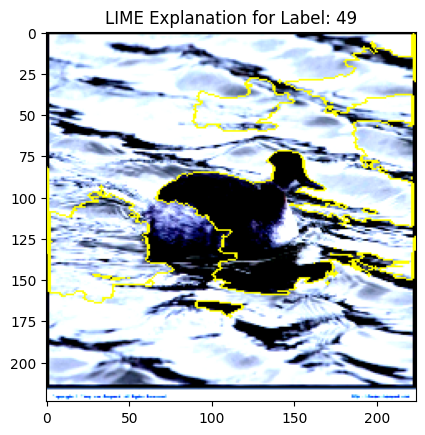

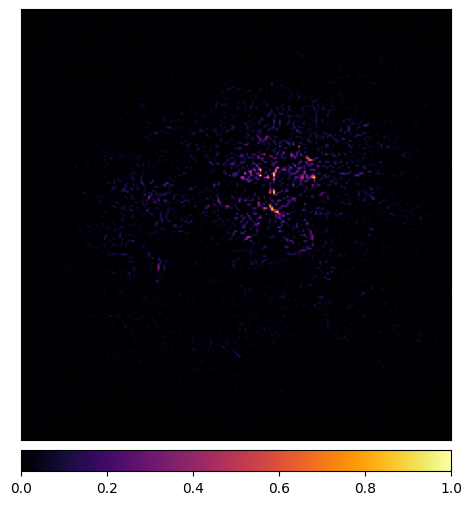

  0%|          | 0/1000 [00:00<?, ?it/s]

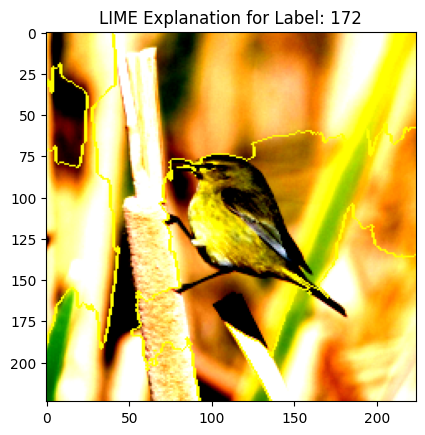

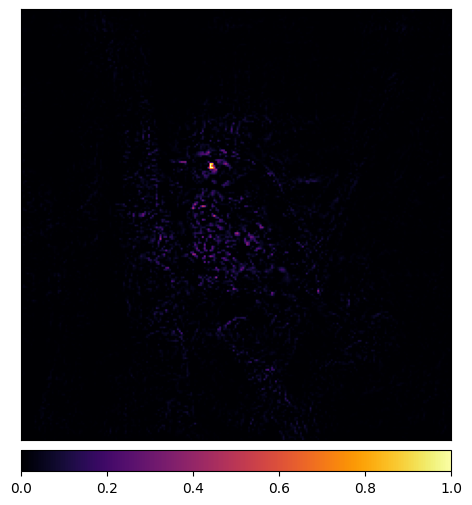

  0%|          | 0/1000 [00:00<?, ?it/s]

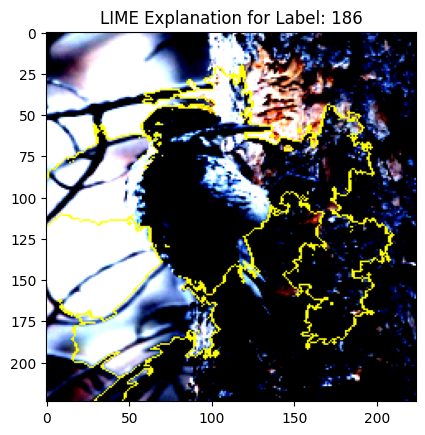

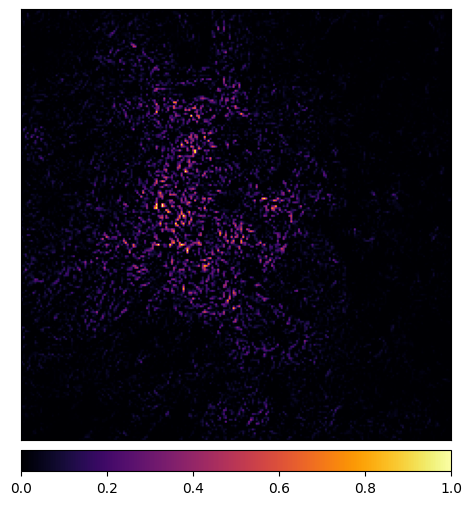

  0%|          | 0/1000 [00:00<?, ?it/s]

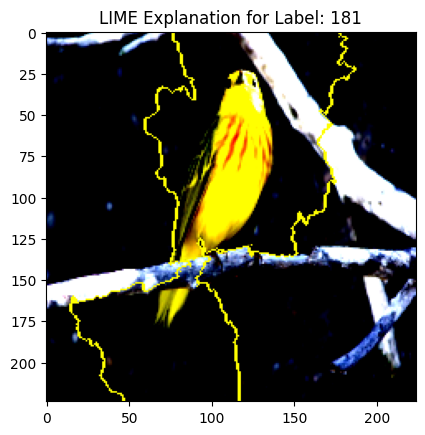

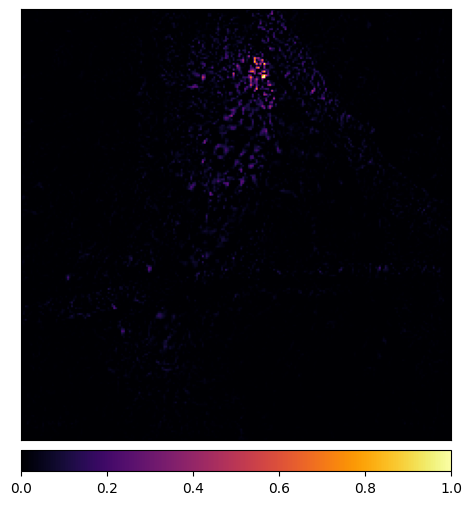

  0%|          | 0/1000 [00:00<?, ?it/s]

Label 183 not in LIME explanation for image 5321


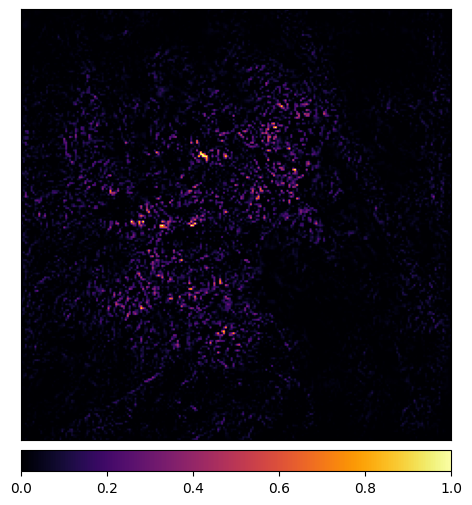

  0%|          | 0/1000 [00:00<?, ?it/s]

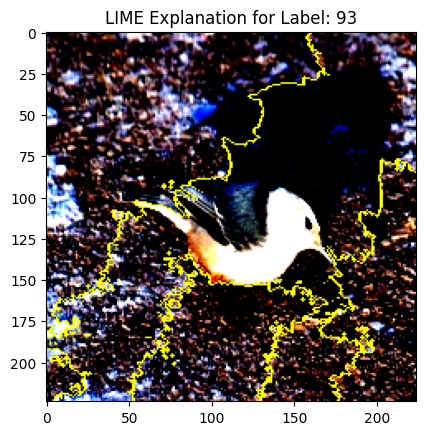

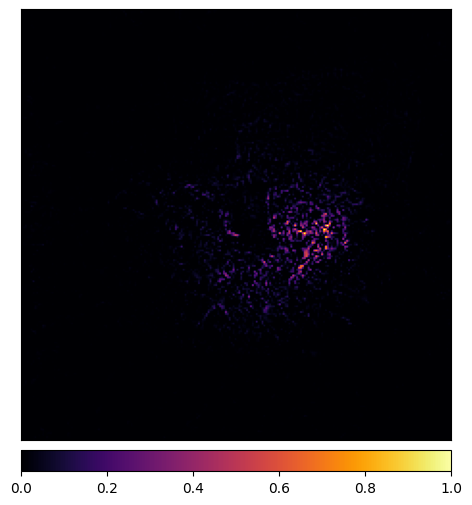

  0%|          | 0/1000 [00:00<?, ?it/s]

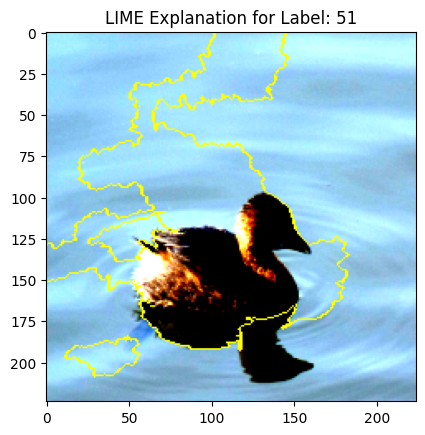

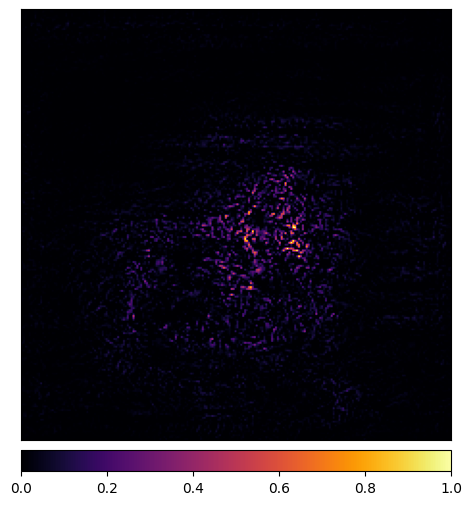

  0%|          | 0/1000 [00:00<?, ?it/s]

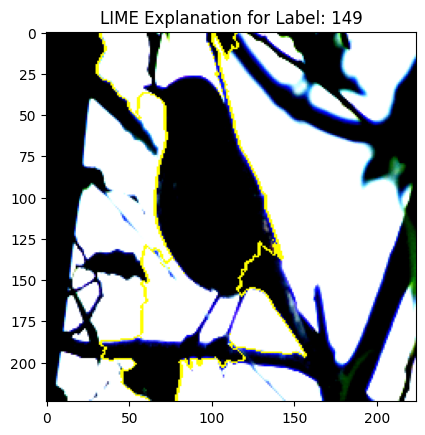

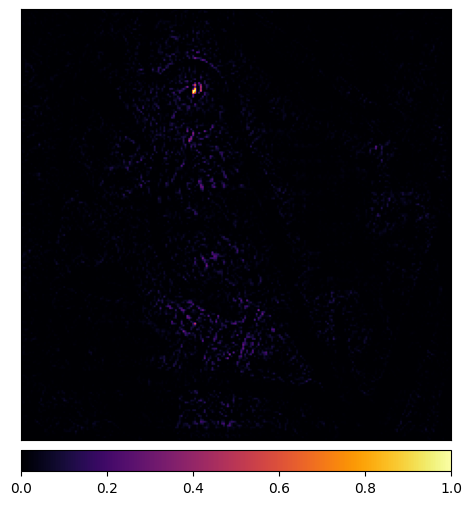

  0%|          | 0/1000 [00:00<?, ?it/s]

Label 148 not in LIME explanation for image 4269


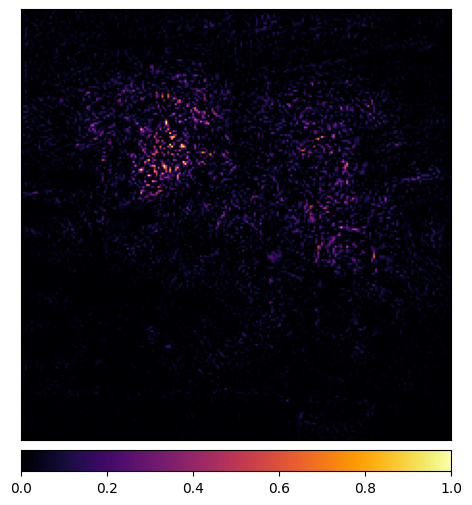

  0%|          | 0/1000 [00:00<?, ?it/s]

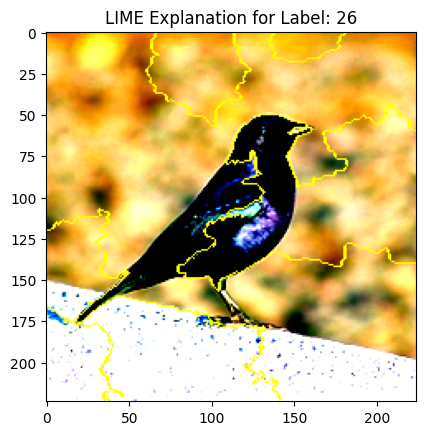

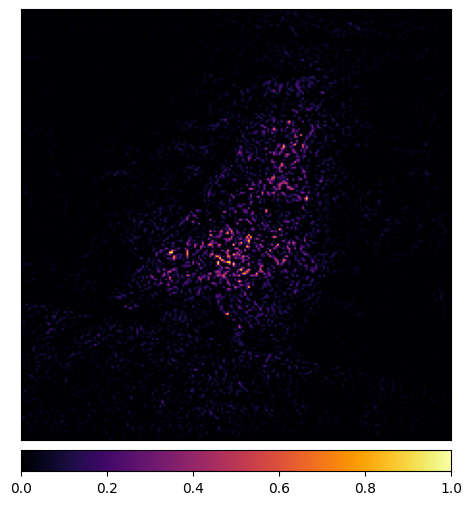

  0%|          | 0/1000 [00:00<?, ?it/s]

Label 170 not in LIME explanation for image 4932


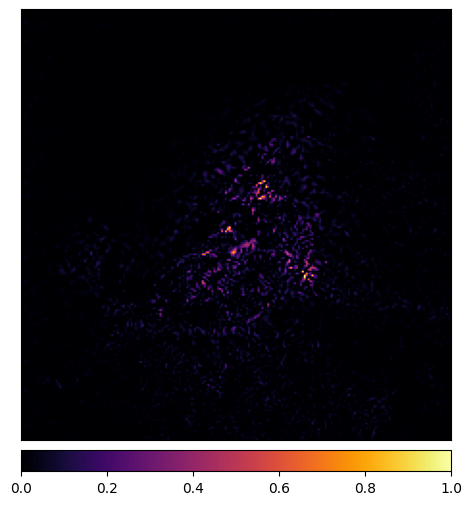

  0%|          | 0/1000 [00:00<?, ?it/s]

Label 36 not in LIME explanation for image 999


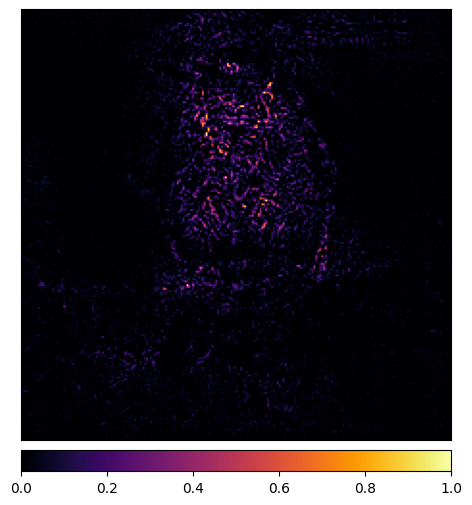

  0%|          | 0/1000 [00:00<?, ?it/s]

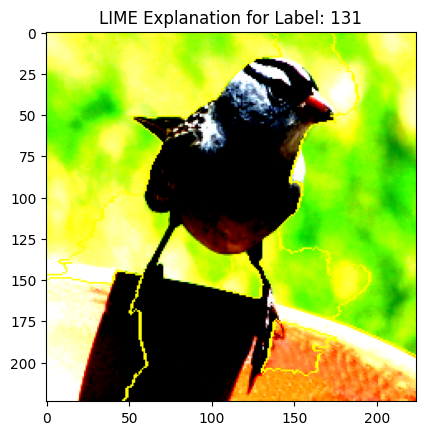

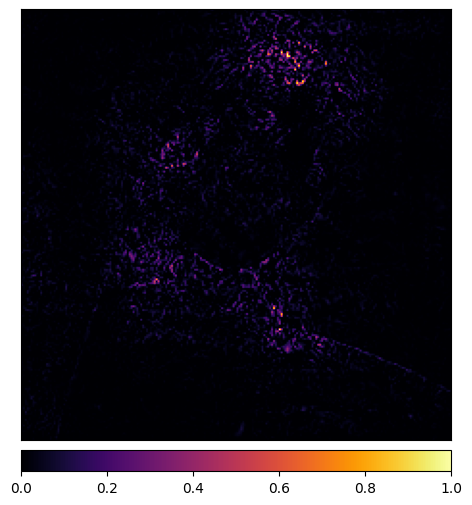

  0%|          | 0/1000 [00:00<?, ?it/s]

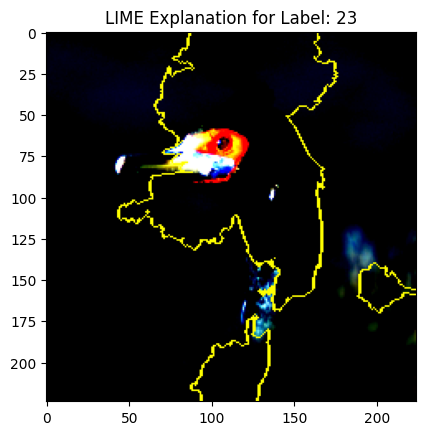

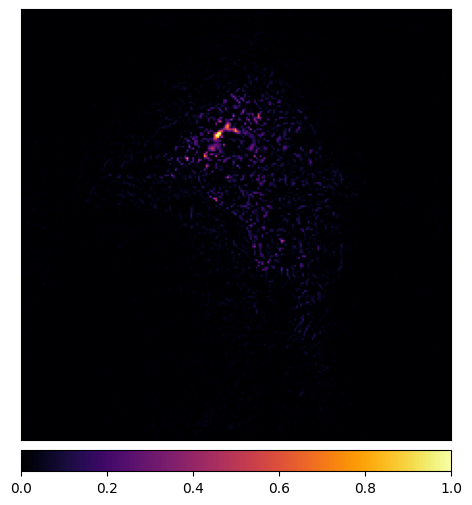

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Select a representative subset of indices (10 random)
subset_indices = np.random.choice(len(test_dataset), size=10, replace=False)
explanation_dir = '/content/drive/My Drive/LCT TRENTO/ML FINAL PROJECT/CUB_200_2011/CUB_200_2011/explanations'
os.makedirs(explanation_dir, exist_ok=True)

generate_explanations(model, test_dataset, subset_indices, device, explanation_dir)

2) Meassure and evaluate faithfullness of each method.




In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from captum.attr import IntegratedGradients

def explain_with_lime(model, image, device):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image,
        classifier_fn=lambda x: model(torch.tensor(x).permute(0, 3, 1, 2).to(device)).detach().cpu().numpy(),
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )
    return explanation

def explain_with_integrated_gradients(model, image, label, device):
    ig = IntegratedGradients(model)
    image_tensor = image.unsqueeze(0).to(device)
    attributions_ig = ig.attribute(image_tensor, target=label.item(), n_steps=200)
    return attributions_ig

def perturb_image(image, mask, top_k):
    perturbed_image = image.copy()
    mask_flat = mask.flatten()
    top_k_indices = mask_flat.argsort()[-top_k:][::-1]
    for index in top_k_indices:
        x, y = np.unravel_index(index, mask.shape)
        perturbed_image[x, y, :] = 0  # Set the top-k important pixels to zero (blackout)
    return perturbed_image

def measure_impact(model, original_image, perturbed_image, device):
    model.eval()
    original_image_tensor = torch.tensor(original_image).permute(2, 0, 1).unsqueeze(0).to(device)
    perturbed_image_tensor = torch.tensor(perturbed_image).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        original_output = model(original_image_tensor)
        perturbed_output = model(perturbed_image_tensor)
    return original_output, perturbed_output

def evaluate_explanation_impact(model, dataset, indices, device, top_k=5):
    for idx in indices:
        image, label, _, _ = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()

        # LIME explanation
        lime_explanation = explain_with_lime(model, image_np, device)
        lime_temp, lime_mask = lime_explanation.get_image_and_mask(
            lime_explanation.top_labels[0], positive_only=True, num_features=top_k, hide_rest=False
        )
        lime_perturbed_image = perturb_image(image_np, lime_mask, top_k)
        original_output, lime_perturbed_output = measure_impact(model, image_np, lime_perturbed_image, device)
        print(f"Original prediction for Image {idx}: {original_output}")
        print(f"LIME perturbed prediction for Image {idx}: {lime_perturbed_output}")

        # IG explanation
        ig_attributions = explain_with_integrated_gradients(model, image, label, device)
        ig_mask = ig_attributions.squeeze().cpu().detach().numpy().sum(axis=0)
        ig_top_k_mask = np.zeros_like(ig_mask)
        ig_flat = ig_mask.flatten()
        top_k_indices = ig_flat.argsort()[-top_k:][::-1]
        for index in top_k_indices:
            x, y = np.unravel_index(index, ig_mask.shape)
            ig_top_k_mask[x, y] = 1
        ig_perturbed_image = perturb_image(image_np, ig_top_k_mask, top_k)
        original_output, ig_perturbed_output = measure_impact(model, image_np, ig_perturbed_image, device)
        print(f"IG perturbed prediction for Image {idx}: {ig_perturbed_output}")

# Example subset of indices to test
subset_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

model.eval()
with torch.no_grad():
    evaluate_explanation_impact(model, test_dataset, subset_indices, device, top_k=5)

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 1: tensor([[  8.1620,   0.2412,  -5.4259, -15.9574,  -7.1977, -16.6357, -14.0102,
          -2.1050, -10.4544, -14.9946,   0.6931, -10.9555, -11.0403, -12.9942,
         -13.6325, -11.8069,  -9.0158, -20.0084, -11.5982, -14.5402,  -6.3111,
         -13.6863,  -5.3604, -10.9252,  -6.3961, -11.9272, -11.8796, -13.7979,
         -13.2697,  -5.1040,  -6.5304,  -2.4129,  -4.6222,  -2.2119, -13.6509,
         -11.1577, -21.9409, -13.1415, -13.9922, -17.5866,  -8.6731, -16.7527,
         -16.7394,  -7.6420,  -7.9765,   1.7115, -12.5165,  -9.6890,  -5.4720,
          -8.9546, -10.4163,  -9.1290, -10.8064,  -8.0233,  -5.7711,  -8.6117,
         -16.1398,  -8.1379, -10.3878,  -9.6869,  -6.2733,  -7.1087, -11.3105,
          -5.9551, -10.4709,  -6.1422, -13.9713, -11.5684,  -9.5251, -20.0998,
          -2.6704,  -8.3313, -11.3165,  -4.6182, -12.0387,  -6.7186, -14.4439,
          -7.5002, -15.3201, -14.4688, -16.3290,  -7.9178,  -7.3039, -13.8163,
          -7.4123, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 2: tensor([[ -0.9750,  -4.5887,  -2.5629,  -7.7341,  -3.8611,  -5.2967,  -8.8461,
           1.4394,  -3.7676,  -7.0049,  -4.7457,  -7.8657,  -7.3329,  -8.7891,
         -13.0332,  -8.3652,  -8.7921,  -8.7586, -14.0681,  -7.4858,  -7.4893,
          -5.2275,   0.9283,  -3.3090,  -0.9394,  -7.5007,  -5.6232,  -7.5147,
          -6.7884,  -1.8551, -13.3038,  -6.0193, -13.5662,  -4.4333, -10.2636,
          -6.5125, -13.8190, -13.0329, -16.0822,  -7.8613, -10.2166, -11.1173,
         -13.8027,  -0.1535,  -6.0441,  -4.4526, -12.9306, -12.6841,  -5.5090,
          -4.9806,  -4.9684,  -1.5206,  -6.4888,  -2.8502,  -9.0586, -12.1717,
         -12.1279,  -3.8517, -13.1066, -14.7464, -10.1703,  -7.9329, -11.9314,
          -7.0816,  -7.7505, -10.0322,  -7.5370,  -6.1685,  -8.7097, -10.0270,
          -4.2649,  -1.1944, -10.0259,  -6.6224,  -9.2481,  -8.6197, -10.4088,
          -8.6659,  -6.7419,  -6.3353,  -5.5602,  -2.0689,  -3.2605, -13.8747,
          -8.0102, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 3: tensor([[ -0.2179,  -2.1759,   0.5917, -10.7876,  -2.4840,  -9.1293,  -5.6518,
          -4.9802,  -2.3721, -11.1019,  -1.5154, -10.8898, -11.3006,  -8.3374,
         -15.6172, -12.8225,  -8.9052, -13.0921,  -3.9590, -14.7913,  -9.2040,
         -10.7954,  -1.8983,  -5.4719,  -1.2560,  -7.1609,  -3.3777,  -8.6623,
          -5.5012,  -2.6446,  -9.1717,  -7.1647,  -7.1845,  -6.2348, -12.1044,
         -10.2647, -18.4823, -12.0448, -14.2374, -13.5642, -13.6491, -14.1045,
         -14.7456,  -7.2604,  -6.8722,  -3.2741, -13.6409, -11.3927,  -2.7467,
         -11.1979, -11.9336, -11.8147,  -9.4061,  -8.4264,  -7.0210,  -9.9466,
         -14.1735,  -0.1750,  -7.2551,  -2.3658,  -1.4494,  -6.9284,  -9.6288,
          -3.0688,  -7.3472,  -1.0120, -12.1062, -11.6601, -13.8691, -14.2636,
           1.0937,  -7.2299,  -7.1879,  -4.2527,  -6.0054,  -9.0444, -10.6282,
          -7.2352, -12.7082, -12.7607, -13.4714,  -9.5644,  -7.8870,  -8.3759,
          -8.3705, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 4: tensor([[  0.0829,  -6.6437,  -5.2838, -10.6959,  -4.2812,  -8.3084, -10.1041,
           2.7838,  -7.9811,  -9.6464,  -5.5949,  -7.5460, -10.0149, -13.5281,
         -15.9148, -12.1620,  -9.5807, -12.9395, -18.4681,  -7.8386,  -8.9896,
          -7.3811,  -0.8761,  -4.1278,  -3.7364, -11.3687,  -9.3990,  -9.3605,
         -10.4179,  -3.8045, -12.9148,  -6.4103, -15.5018,  -5.6283, -11.1944,
          -7.5607, -14.4571, -13.3953, -15.8716,  -5.9838, -11.4583, -12.7241,
         -13.8388,  -0.4937,  -5.1896,  -2.1711, -14.6908, -12.5222,  -8.5691,
          -5.1642,  -6.5513,  -1.1778,  -9.4864,  -7.5490, -10.6832, -11.2482,
         -15.4899,  -6.6547, -12.4225, -16.2889, -11.5010,  -6.2503, -12.7034,
          -8.7557,  -6.6853, -11.0558,  -6.9304,  -7.3257,  -7.8829, -12.2939,
          -5.3921,   0.6861, -16.6512,  -7.7603, -14.6756,  -9.2131, -11.0733,
          -8.8697,  -8.6535,  -8.3286,  -9.5151,  -4.3647,  -5.1344, -15.6223,
          -9.3761, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 5: tensor([[ -5.9889,  -3.2117,  -3.9009, -10.6530,  -4.8496,  -7.5740,  -6.8907,
          -8.0316,  -1.8598, -10.7473,  -3.3177,  -9.7793,  -9.6705,  -4.5982,
          -9.5353, -11.6767, -10.9669,  -8.9248,  -4.1191, -12.6894, -12.3294,
         -12.4256,  -2.2752,  -4.4183,  -4.6957,  -6.1997,  -3.3878, -11.8645,
          -7.9308,  -6.6410, -13.0199, -12.2595,  -8.7463,  -5.4796, -12.8802,
          -8.5291, -18.4674, -12.5981, -13.2387, -11.1428, -13.2250, -15.4834,
         -10.8914,  -9.8923,  -9.4721,  -8.5774, -15.7117, -13.4135,  -2.9420,
          -9.1896,  -9.8036, -10.7767,  -7.7333,  -5.1991,  -7.5487,  -7.7239,
         -14.9598,  -6.8551,  -7.1704,  -3.5052,  -4.9985,  -4.2687,  -7.3338,
          -0.5749,  -7.4433,  -1.7561, -10.7210, -10.5700, -14.6454, -10.7567,
          -5.7367,  -7.5372,  -2.6109,  -0.5554,  -4.7502,  -6.7710, -12.1223,
          -7.1970,  -9.4758, -12.7459, -11.1403, -10.5428,  -8.0819, -12.1548,
          -6.7258, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 6: tensor([[  4.2234,  -1.5717,  -3.6796, -14.7778,  -7.2477,  -8.4531,  -9.9708,
           0.1285,  -7.8091, -13.7885,  -3.3713,  -9.6388, -10.5073, -10.9029,
         -14.5524, -12.0249,  -7.6056, -13.2337, -11.7572, -11.1118,  -7.6946,
          -7.9975,  -4.8342,  -7.8256,  -5.1142, -12.3635,  -8.4138,  -9.0167,
          -8.9687,  -5.8668,  -7.2254,  -7.0443,  -7.9882,  -3.4261,  -9.0509,
          -9.0050, -10.9912, -12.7782, -12.1680,  -9.2744,  -8.9109, -14.3108,
         -12.1105,  -4.2745,  -0.3943,   0.2404, -11.0832, -10.8075,  -7.4125,
          -7.3816,  -6.6138,  -5.8284,  -6.3254,  -9.6915,  -9.3138,  -8.2941,
         -12.6359,  -6.9095,  -4.5211,  -6.5682,  -4.7277,  -0.8111,  -4.2636,
          -4.1132,  -0.7776,  -4.8248, -10.4875,  -7.9705,  -6.5247, -14.5532,
          -0.0783,   2.0446, -13.3837,  -8.3133, -14.5491,  -7.1595, -11.6816,
          -6.1787, -11.4039, -10.1993,  -8.4435,  -7.0611,  -7.4160,  -8.6603,
          -5.2471, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 7: tensor([[  8.2951,   3.8752,   3.9628, -10.0167,  -3.8473,  -8.9458,  -9.7891,
           0.3766,  -6.0804, -13.6493,  -7.4731,  -7.0052,  -9.8482, -10.0156,
         -16.1279, -13.5054,  -9.9975, -12.6105, -12.6786, -10.5393, -13.8591,
          -9.1892,   5.9970,  -1.6885,   2.6872, -10.1697,  -7.9853, -10.3638,
         -10.1243,  -2.0166,  -5.5231,  -4.9069, -10.7073,  -8.9998, -10.8606,
         -11.3575, -11.6150, -10.7230, -13.3913,  -6.3064, -12.2924, -14.6838,
          -8.5717,  -1.6598,   2.1385,  -0.9237, -11.7140, -14.4893,  -2.4150,
          -3.1419,  -6.0836,  -2.7318,  -4.2926,  -9.0138,  -9.5620, -13.2148,
         -16.2335,  -4.5858,  -8.1010,  -8.0436,  -4.8940,  -4.8516, -11.7228,
          -4.3037,  -4.0084,  -3.8809, -10.9150,  -5.9246,  -9.0473, -11.6624,
           1.3894,   5.7671, -13.0703,  -5.3489,  -9.0942, -10.0083,  -6.5808,
          -4.6371, -11.4306, -12.3096,  -9.7086,  -9.1479,  -5.5559, -10.1829,
          -8.3461, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 8: tensor([[ 2.0792e+00,  5.2289e-03,  1.0936e+00, -1.3033e+01, -5.4892e+00,
         -5.7261e+00, -9.1961e+00, -2.7257e+00, -3.2013e+00, -1.3945e+01,
         -6.4602e+00, -1.0810e+01, -1.0448e+01, -8.9190e+00, -1.5102e+01,
         -1.2725e+01, -1.0890e+01, -1.2124e+01, -7.0048e+00, -1.0949e+01,
         -1.3260e+01, -1.1621e+01, -1.7850e+00, -6.5662e+00, -3.5207e+00,
         -1.1102e+01, -5.5957e+00, -1.1523e+01, -7.6246e+00, -7.4660e+00,
         -1.0999e+01, -1.0489e+01, -1.1554e+01, -5.0945e+00, -1.2487e+01,
         -1.0554e+01, -1.1826e+01, -1.3008e+01, -1.2972e+01, -6.7274e+00,
         -1.0515e+01, -1.4914e+01, -1.1645e+01, -6.5769e+00,  2.5184e+00,
         -2.6456e+00, -1.3158e+01, -1.5271e+01, -6.4872e+00, -7.8463e+00,
         -7.0464e+00, -6.9960e+00, -4.9756e+00, -8.1572e+00, -9.5770e+00,
         -1.2136e+01, -1.4695e+01, -4.3042e+00, -4.7397e+00, -1.5626e+00,
         -2.5040e+00, -1.1546e+00, -3.5203e+00, -1.3752e+00,  4.3554e-02,
     

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 9: tensor([[  1.5022,  -6.1705,  -5.1949, -14.9121,  -4.7929,  -7.3362,  -7.8346,
          -1.9617,  -7.0539, -13.1829,  -3.5356, -11.7972, -12.0739, -11.5794,
         -13.0941, -13.5403, -10.9519, -14.3794, -12.6075, -14.3060,  -7.0163,
         -11.6111,  -4.5884,  -8.8367,  -7.6445, -10.1931, -10.1641,  -9.5511,
         -11.3167,  -9.6814, -10.5783, -11.8247, -13.0935,  -1.5534,  -8.6192,
          -8.0774, -17.6134, -13.0376, -11.6501,  -9.4596, -12.8181, -14.8260,
         -12.2725, -11.4438,  -5.8383,   2.1024, -17.4690, -10.1138,  -8.4811,
          -4.7489,  -7.7524,  -3.1421,  -8.4849,  -6.2544,  -8.5839,  -8.8286,
         -16.5262,  -5.4874,  -9.7935,  -7.2074,  -6.2372,  -3.6067,  -9.5887,
          -3.2765,  -3.9925,  -7.2806,  -8.8375,  -9.4115,  -8.0480, -16.3749,
          -6.1230,  -4.6495, -10.6713,  -3.8924, -13.2468,  -3.5420, -14.9331,
          -9.0968, -11.0334, -10.5291, -12.5182,  -8.2315,  -6.9977, -12.4278,
          -6.0828, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Original prediction for Image 10: tensor([[ -1.0192,  -3.9423,  -5.9050, -11.9023,  -5.1015,  -5.3284,  -4.4376,
          -3.3927,  -8.8398, -11.6957,  -4.3608,  -9.8579, -11.5961, -11.2612,
         -10.6405,  -9.9349,  -5.8241, -10.6029, -10.2660, -11.0988,  -7.7770,
          -5.6339,  -4.2563,  -6.5500,  -6.2699,  -8.5372, -10.1241,  -3.7781,
         -11.2977,  -8.6191,  -6.3535,  -9.5580, -10.3786,  -2.2880,  -4.5618,
          -4.6057, -11.8798, -11.5940,  -9.2818,  -8.8598,  -8.8974,  -9.7222,
         -10.1290,  -6.4894,  -4.8357,  -3.9183, -12.4734,  -7.4659, -10.2194,
          -7.5533,  -5.0683,  -5.8594,  -7.9484,  -8.6199,  -9.8884,  -3.8733,
         -10.7000,  -5.3548,  -8.3183,  -4.8171,  -4.7641,  -4.1168,  -4.6945,
          -5.2037,  -2.4688,  -6.5052,  -7.6301,  -7.5653,  -6.8813, -13.5973,
          -2.5168,  -5.9009,  -9.6169,  -7.3643, -10.4460,  -5.6722, -12.3771,
          -6.6967, -10.6510,  -7.6226, -10.3643,  -7.4875,  -6.3383,  -6.9222,
          -5.1122,

3) Computation time (efficiency)

In [ ]:
import time
import numpy as np

def measure_computational_efficiency(model, dataset, indices, device, num_examples=10):
    lime_times = []
    ig_times = []

    for idx in indices[:num_examples]:
        image, label = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()

        # Measure LIME time
        start_time = time.time()
        _ = explain_with_lime(model, image_np, device)
        lime_times.append(time.time() - start_time)

        # Measure Integrated Gradients time
        start_time = time.time()
        _ = explain_with_integrated_gradients(model, image, label, device)
        ig_times.append(time.time() - start_time)

    return np.mean(lime_times), np.mean(ig_times)

subset_indices = subset_indices[:10]

lime_time, ig_time = measure_computational_efficiency(model, test_dataset, subset_indices, device)
print(f'Average LIME Time: {lime_time} seconds, Average IG Time: {ig_time} seconds')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Average LIME Time: 90.16640138626099 seconds, Average IG Time: 53.3726089477539 seconds
